# Church-to-Bar Ratio per U.S. County (4th Edition)

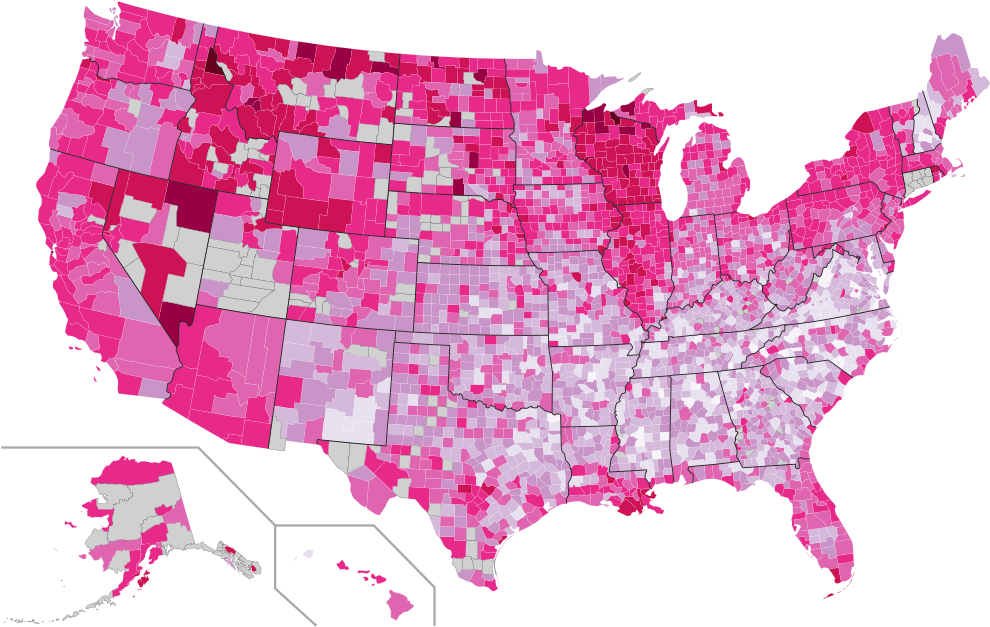

In [1]:
from IPython.display import Image; Image(filename='church_to_bar_ratio_by_US_county_LATEST.png')

The brighter the color, the higher the church-to-bar ratio. Counties missing data necessary for the computation are shown in black.

##### Method

From the latest (2022) County Business Patterns data published by the U.S. Census Bureau at https://data.census.gov/table/CBP2022.CB2200CBP, I extracted the number of establishments in each county that have NAICS codes 813110 (places of worship including churches, temples, mosques, synagogues, etc.) and 722410 (bars, taverns, drink-serving nightclubs, etc.). For each county, I then divided the number of NAICS 813110 establishments by the number of NAICS 722410 establishments to get the “church to bar ratio”. Before dividing I added one (a pseudocount) to each value to prevent division by zero errors. Finally, I partitioned the resulting ratio distribution into nine color groups, and plotted each county’s ratio color on the map. Used log-transformed values when creating the partitions. Counties missing both NAICS codes in the source data are shown in black on the map. Source code implementing these calculations is attached, to facilitate peer review.

I typically publish these results every two years as new data becomes available. This is the fourth such release.

##### Results

The "Bible Belt" shows up in brighter colors, as we'd expect. In Texas, Travis County--the home of Austin--is a booze cesspool compared to neighboring (and more straight-edge) Williamson County, again, as we'd expect. Finally, New Orleans looks like a lot of fun!

These three observations roughly validate the method.

##### Possible bias in the result

If NAICS code 813110 excludes church facilities with unpaid staff and clergy—i.e., if the Census Bureau does not to consider them “places of industry” since no one is getting paid to work there—the LDS presence in the west will be severely underrepresented. This warrants further review of NAICS measurement methodology before producing future map updates. Reader comments on the appropriateness of NAICS industry codes for this study are very welcome!

## Load the libraries we need

In [2]:
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup

## User settings

In [3]:
year = 2022

filename_cbp = os.environ['BDS_HOME'] + '/badassdatascience/econometrics/church_to_bar_ratio/' + str(year) + '/data' + '/CBP2022.CB2200CBP-Data.csv'
output_directory = os.environ['BDS_HOME'] + '/badassdatascience/econometrics/church_to_bar_ratio/' + str(year) + '/output'
data_directory = os.environ['BDS_HOME'] + '/badassdatascience/econometrics/church_to_bar_ratio/' + str(year) + '/data'

output_file = output_directory + '/church_to_bar_ratio_by_US_county_' + str(year) + '.svg'

# these are imported as strings due to non-numeric characters in a few rows for this column
naics_drinking_places = '722410'
naics_religious_organizations = '813110'

number_of_groups = 9
map_svg = data_directory + '/Usa_counties_large.svg'
colors = ['#000000', '#F7F4F9', '#E7E1EF', '#D4B9DA', '#C994C7', '#DF65B0', '#E7298A', '#CE1256', '#980043', '#67001F']

path_style = 'font-size:12px;fill-rule:nonzero;stroke:#FFFFFF;stroke-opacity:1;stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt;marker-start:none;stroke-linejoin:bevel;fill:'

## Define a function to obtain the FIPS code from a GEO_ID

In [4]:
def get_FIPS(item):
    new_item = item.strip().split('US')[-1]
    if len(new_item) < 5:
        return np.nan
    else:
        return new_item
    return new_item

## Load and pre-process the County Business Patterns data

As of 2025-01-18, the most recent year the US Census Bureau put this information out is 2022.

In [5]:
naics_list = [naics_drinking_places, naics_religious_organizations]

df = (
    pd.read_csv(filename_cbp, low_memory=False)
    .iloc[1:, :]
    .astype(
        {
            'ESTAB' : 'int64',
            'YEAR' : 'int64',
        }
    )
)

df = df[(df['YEAR'] == year) & (df['NAICS2017'].isin(naics_list))]
df['FIPS'] = df['GEO_ID'].apply(get_FIPS)
df = df[['FIPS', 'NAICS2017', 'ESTAB']]
df = df.dropna()

In [6]:
df

,FIPS,NAICS2017,ESTAB
1404659,01001,813110,52
1404660,01001,813110,27
1404661,01001,813110,15
1404662,01001,813110,6
1406963,01003,722410,23
...,...,...,...
4336705,72149,813110,3
4336878,72151,813110,3
4337230,72153,722410,4
4337280,72153,813110,9


## Aggregate to compute the count of establishments per (FIPS, NAICS) pair

It looks like the NAICS values considered were specified in 2017 and the source data explicitly says so in that columns header name:

In [7]:
df_agg = (
    df
    .groupby(['FIPS', 'NAICS2017'])
    ['ESTAB']
    .agg(
        'sum'
    )
)

df_agg = df_agg.reset_index()

In [8]:
df_agg

,FIPS,NAICS2017,ESTAB
0,01001,813110,100
1,01003,722410,46
2,01003,813110,351
3,01005,813110,40
4,01007,813110,36
...,...,...,...
4644,72147,722410,11
4645,72149,813110,6
4646,72151,813110,3
4647,72153,722410,4


## Divide the set by NAICS to prepare for join by FIPS code

I suppose we could create a pivot table instead for this task, but this works and is easy to understand:

In [9]:
df_drinking_places = df_agg[df_agg['NAICS2017'] == naics_drinking_places].copy()
df_drinking_places['drinking_places'] = df_drinking_places['ESTAB']
df_drinking_places = df_drinking_places.drop(columns = ['ESTAB']).sort_values(by = ['FIPS'])

df_religious_organizations = df_agg[df_agg['NAICS2017'] == naics_religious_organizations].copy()
df_religious_organizations['religious_organizations'] = df_religious_organizations['ESTAB']
df_religious_organizations = df_religious_organizations.drop(columns = ['ESTAB']).sort_values(by = ['FIPS'])

In [10]:
df_drinking_places

,FIPS,NAICS2017,drinking_places
1,01003,722410,46
16,01031,722410,9
18,01033,722410,4
25,01045,722410,8
31,01055,722410,10
...,...,...,...
4633,72131,722410,4
4636,72135,722410,7
4638,72137,722410,8
4644,72147,722410,11


In [11]:
df_religious_organizations

,FIPS,NAICS2017,religious_organizations
0,01001,813110,100
2,01003,813110,351
3,01005,813110,40
4,01007,813110,36
5,01009,813110,78
...,...,...,...
4642,72143,813110,27
4643,72145,813110,11
4645,72149,813110,6
4646,72151,813110,3


## Join so we obtain both counts per FIPS code on the same row

In [12]:
df_cbr = pd.merge(
    df_religious_organizations[['FIPS', 'religious_organizations']],
    df_drinking_places[['FIPS', 'drinking_places']],
    on = ['FIPS'],
    how = 'left',
).sort_values(by = ['FIPS'])

In [13]:
df_cbr

,FIPS,religious_organizations,drinking_places
0,01001,100,NaN
1,01003,351,46.0
2,01005,40,NaN
3,01007,36,NaN
4,01009,78,NaN
...,...,...,...
3042,72143,27,NaN
3043,72145,11,NaN
3044,72149,6,NaN
3045,72151,3,NaN


## Add a pseudocount to prevent divide by zero issues

We first fill the NaN values with zeros.

In [14]:
df_cbr = df_cbr.fillna(0.)
df_cbr['religious_organizations'] = df_cbr['religious_organizations'] + 1.
df_cbr['drinking_places'] = df_cbr['drinking_places'] + 1.

In [15]:
df_cbr

,FIPS,religious_organizations,drinking_places
0,01001,101.0,1.0
1,01003,352.0,47.0
2,01005,41.0,1.0
3,01007,37.0,1.0
4,01009,79.0,1.0
...,...,...,...
3042,72143,28.0,1.0
3043,72145,12.0,1.0
3044,72149,7.0,1.0
3045,72151,4.0,1.0


## Compute the church to bar ratio and its log10

In [16]:
df_cbr['church_to_bar_ratio'] = df_cbr['religious_organizations'] / df_cbr['drinking_places']
df_cbr['log10_church_to_bar_ratio'] = np.log10(df_cbr['church_to_bar_ratio'])

In [17]:
df_cbr

,FIPS,religious_organizations,drinking_places,church_to_bar_ratio,log10_church_to_bar_ratio
0,01001,101.0,1.0,101.000000,2.004321
1,01003,352.0,47.0,7.489362,0.874445
2,01005,41.0,1.0,41.000000,1.612784
3,01007,37.0,1.0,37.000000,1.568202
4,01009,79.0,1.0,79.000000,1.897627
...,...,...,...,...,...
3042,72143,28.0,1.0,28.000000,1.447158
3043,72145,12.0,1.0,12.000000,1.079181
3044,72149,7.0,1.0,7.000000,0.845098
3045,72151,4.0,1.0,4.000000,0.602060


## QA

#### Should be empty

In [18]:
df_cbr[df_cbr['church_to_bar_ratio'].isna()]

,FIPS,religious_organizations,drinking_places,church_to_bar_ratio,log10_church_to_bar_ratio


In [19]:
df_cbr[df_cbr['log10_church_to_bar_ratio'].isna()]

,FIPS,religious_organizations,drinking_places,church_to_bar_ratio,log10_church_to_bar_ratio


#### Review the value ranges

In [20]:
print(np.min(df_cbr['church_to_bar_ratio']), np.max(df_cbr['church_to_bar_ratio']))

0.12903225806451613 400.0


In [21]:
print(np.min(df_cbr['log10_church_to_bar_ratio']), np.max(df_cbr['log10_church_to_bar_ratio']))

-0.8893017025063104 2.6020599913279625


## Shift the values so no negative ones remain

In [22]:
min_log10 = np.min(df_cbr['log10_church_to_bar_ratio'])
df_cbr['zeroed_log10_church_to_bar_ratio'] = df_cbr['log10_church_to_bar_ratio'] - min_log10

## Define the color cutpoints

In [23]:
color_interval = np.max(df_cbr['zeroed_log10_church_to_bar_ratio']) / np.float64(number_of_groups)

cutpoints = []
for n in range(0, np.int32(number_of_groups)):
    start = color_interval * np.float64(n)
    end = color_interval * np.float64(n + 1)
    cutpoints.append( (n, start, end) )

In [24]:
cutpoints

[(0, 0.0, 0.38792907709269703),
 (1, 0.38792907709269703, 0.7758581541853941),
 (2, 0.7758581541853941, 1.163787231278091),
 (3, 1.163787231278091, 1.5517163083707881),
 (4, 1.5517163083707881, 1.9396453854634852),
 (5, 1.9396453854634852, 2.327574462556182),
 (6, 2.327574462556182, 2.7155035396488794),
 (7, 2.7155035396488794, 3.1034326167415762),
 (8, 3.1034326167415762, 3.491361693834273)]

## Assign the per-county color using the cutpoints

In [25]:
def assign_color_group(item):
    for n, start, end in cutpoints:
        if item >= start and item <= end:
            return np.int32(n)

df_cbr['color_group'] = df_cbr['zeroed_log10_church_to_bar_ratio'].apply(assign_color_group)

## More QA

#### DataFrame should now have a color assignment for each row

In [26]:
df_cbr

,FIPS,religious_organizations,drinking_places,church_to_bar_ratio,log10_church_to_bar_ratio,zeroed_log10_church_to_bar_ratio,color_group
0,01001,101.0,1.0,101.000000,2.004321,2.893623,7
1,01003,352.0,47.0,7.489362,0.874445,1.763747,4
2,01005,41.0,1.0,41.000000,1.612784,2.502086,6
3,01007,37.0,1.0,37.000000,1.568202,2.457503,6
4,01009,79.0,1.0,79.000000,1.897627,2.786929,7
...,...,...,...,...,...,...,...
3042,72143,28.0,1.0,28.000000,1.447158,2.336460,6
3043,72145,12.0,1.0,12.000000,1.079181,1.968483,5
3044,72149,7.0,1.0,7.000000,0.845098,1.734400,4
3045,72151,4.0,1.0,4.000000,0.602060,1.491362,3


#### Should report an empty set

I.e., there are no NaNs in the "color_group" column:

In [27]:
df_cbr[df_cbr['color_group'].isna()]

,FIPS,religious_organizations,drinking_places,church_to_bar_ratio,log10_church_to_bar_ratio,zeroed_log10_church_to_bar_ratio,color_group


## Create a lookup dictionary matching FIPS to color

There might be a more elegant way to do this completely in Pandas, but that is left as an exercise for the reader!

In [28]:
color_group = {}
for v, g in zip(df_cbr['FIPS'], df_cbr['color_group']):
    color_group[v] = g

## Create the map

In [29]:
svg = open(map_svg, 'r').read()
soup = BeautifulSoup(svg, selfClosingTags=['defs','sodipodi:namedview'])
paths = soup.findAll('path')
colors.reverse()


for p in paths:

    plot = False
    if p['class'][0].replace('c', '') in color_group:
        color_class = color_group[p['class'][0].replace('c', '')]
        plot = True

    elif p['class'][0] == 'c':
        color_class = len(colors)
        plot = True

    if plot:
        color = colors[color_class]
        p['style'] = path_style + color

/home/emily/venvs/ml/lib/python3.10/site-packages/bs4/__init__.py:198: UserWarning: BS4 does not respect the selfClosingTags argument to the BeautifulSoup constructor. The tree builder is responsible for understanding self-closing tags.
  warnings.warn(
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


## Save the map

In [30]:
with open(output_file, 'w') as f:
    f.write(str(soup.prettify()))

## Display the map

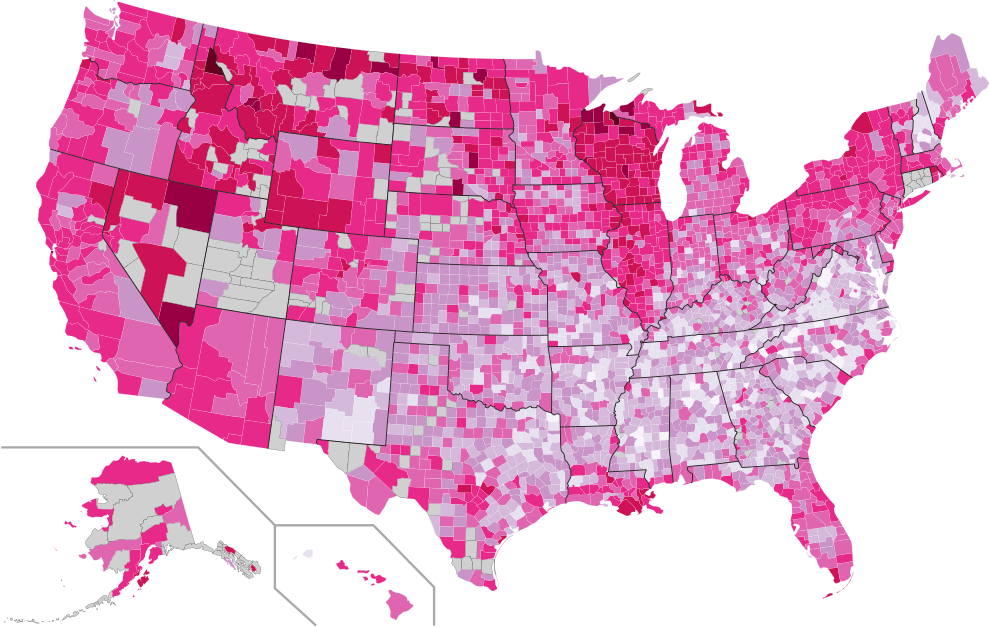

In [31]:
from IPython.display import SVG
SVG(output_file)